In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from PIL import Image
from tensorflow.keras.applications import MobileNetV2 
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import Model

2024-05-30 12:39:05.869423: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-30 12:39:05.869554: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-30 12:39:05.995232: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Initialize Model

In [25]:
def create_model(input_shape, output_shape):
    inputs = tf.keras.Input(shape=input_shape)
    feature_extractor = tf.keras.applications.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(128,128,3)
    )
    extracted_features = feature_extractor(inputs, training=False)
    gap = GlobalAveragePooling2D()(extracted_features)
    fc2 = Dense(output_shape, activation="softmax")(gap)
    model = Model(inputs=inputs, outputs=fc2)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])
    return model

In [26]:
model = create_model(
    input_shape=(128, 128, 3),
    output_shape=3
)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 2,227,715 (8.50 MB)

 Non-trainable params: 34,112 (133.25 KB)

## Prepare Dataset

In [5]:
def preprocess_image(image):
    test_image = image.resize((128, 128),Image.NEAREST)
    test_image = (np.array(test_image))
    test_image = np.expand_dims(test_image, axis=2)
    test_image = np.repeat(test_image, 3, axis=2)
    return test_image

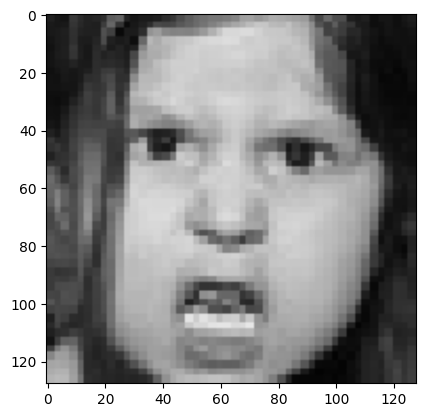

In [6]:
ti = preprocess_image(Image.open("/kaggle/input/face-expression-recognition-dataset/images/train/angry/10002.jpg"))
plt.imshow(ti)
plt.show()

In [9]:
image_dataset_dir = "/kaggle/input/face-expression-recognition-dataset/images/train"
classes = os.listdir(image_dataset_dir)

images_x = []
images_y = []

for class_ in classes:
    class_path = f"{image_dataset_dir}/{class_}"
    for c in tqdm(os.listdir(class_path)):
        image_path = f"{class_path}/{c}"
        image_np = Image.open(image_path)
        image_np = preprocess_image(image_np)
        images_x.append(image_np)
        if class_ in ["happy", "surprise"]:
            images_y.append("Enthusiastic")
        elif class_ in ["neutral"]:
            images_y.append("Neutral")
        else:
            images_y.append("Bad")

100%|██████████| 7164/7164 [00:06<00:00, 1053.16it/s]


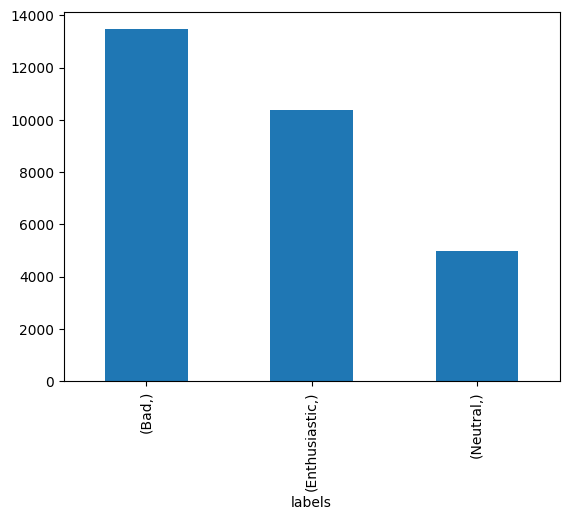

In [16]:
pd.DataFrame({"labels": images_y}).value_counts().plot(kind="bar")
plt.show()

In [17]:
images_x = np.array(images_x)
print(images_x.shape)

(28821, 128, 128, 3)


In [18]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [19]:
images_y_ohe = OneHotEncoder(sparse=True,handle_unknown="ignore")
images_y_ohe_arr = images_y_ohe.fit_transform(np.array(images_y).reshape(-1, 1)).toarray()

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Splits

In [20]:
xtrain, xtest, ytrain, ytest = train_test_split(images_x, images_y_ohe_arr, test_size=0.2, shuffle=True)
print(xtrain.shape, ytrain.shape)

(23056, 128, 128, 3) (23056, 3)


In [21]:
xtrain[0]

array([[[ 26,  26,  26],
        [ 26,  26,  26],
        [ 26,  26,  26],
        ...,
        [ 25,  25,  25],
        [ 25,  25,  25],
        [ 25,  25,  25]],

       [[ 26,  26,  26],
        [ 26,  26,  26],
        [ 26,  26,  26],
        ...,
        [ 25,  25,  25],
        [ 25,  25,  25],
        [ 25,  25,  25]],

       [[ 26,  26,  26],
        [ 26,  26,  26],
        [ 26,  26,  26],
        ...,
        [ 25,  25,  25],
        [ 25,  25,  25],
        [ 25,  25,  25]],

       ...,

       [[ 21,  21,  21],
        [ 21,  21,  21],
        [ 21,  21,  21],
        ...,
        [128, 128, 128],
        [128, 128, 128],
        [128, 128, 128]],

       [[ 21,  21,  21],
        [ 21,  21,  21],
        [ 21,  21,  21],
        ...,
        [128, 128, 128],
        [128, 128, 128],
        [128, 128, 128]],

       [[ 21,  21,  21],
        [ 21,  21,  21],
        [ 21,  21,  21],
        ...,
        [128, 128, 128],
        [128, 128, 128],
        [128, 128, 128]]

## Training

In [27]:
history = model.fit(xtrain, ytrain, validation_split=0.2, epochs=10, shuffle=True)

Epoch 1/10
577/577 ━━━━━━━━━━━━━━━━━━━━ 78s 69ms/step - accuracy: 0.6198 - loss: 0.9111 - val_accuracy: 0.3844 - val_loss: 5.0013
Epoch 2/10
577/577 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.7448 - loss: 0.5952 - val_accuracy: 0.6093 - val_loss: 1.3687
Epoch 3/10
577/577 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.7760 - loss: 0.5499 - val_accuracy: 0.5787 - val_loss: 1.5309
Epoch 4/10
577/577 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.7989 - loss: 0.4965 - val_accuracy: 0.5872 - val_loss: 1.3573
Epoch 5/10
577/577 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.8151 - loss: 0.4544 - val_accuracy: 0.6945 - val_loss: 1.0072
Epoch 6/10
577/577 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.8309 - loss: 0.4206 - val_accuracy: 0.6247 - val_loss: 1.5553
Epoch 7/10
577/577 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.8449 - loss: 0.3913 - val_accuracy: 0.6852 - val_loss: 0.8381
Epoch 8/10
577/577 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.8574 - loss: 0.3564 - 

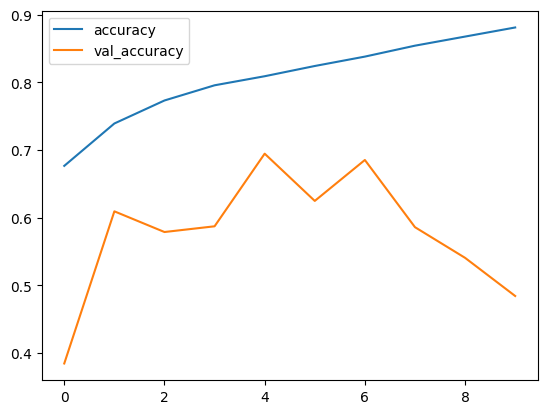

In [28]:
plt.plot(history.history['accuracy'],label="accuracy")
plt.plot(history.history['val_accuracy'],label="val_accuracy")

plt.legend()
plt.show()


## Testing

In [29]:
model.evaluate(xtest, ytest)

181/181 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.4638 - loss: 1.9742


[1.9776710271835327, 0.4622723460197449]

In [30]:
predictions = model.predict(xtrain)
pred_labels = np.argmax(predictions, axis=1)
real_labels = np.argmax(ytrain, axis=1)

721/721 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step


In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

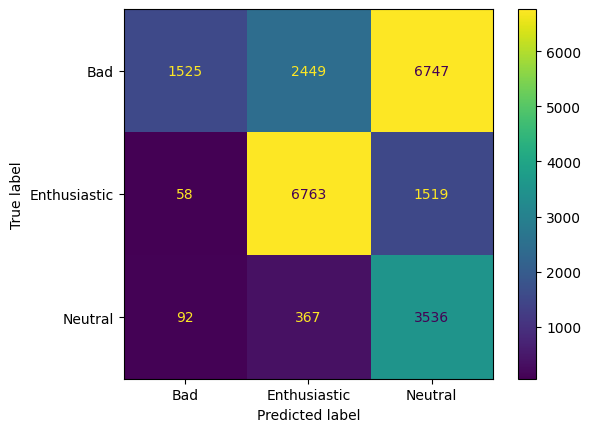

In [32]:
cm = confusion_matrix(real_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=images_y_ohe.categories_[0])
disp.plot()
plt.show()

In [60]:
images_y_ohe.inverse_transform([[0.,0.,1.]])

array([['neutral']], dtype='<U7')

In [74]:
model.save("facial_expr.keras")

In [6]:
new_model = tf.keras.models.load_model('/kaggle/working/facial_expr.keras')


In [1]:
converter = tf.lite.TFLiteConverter.from_keras_model(new_model)
tflite_model = converter.convert()

with open('facial_expr.tflite', 'wb') as f:
  f.write(tflite_model)

NameError: name 'tf' is not defined

In [66]:
def get_dataset(dir_path):
    classes = os.listdir(dir_path)

    good_classes = ["happy", "neutral"]

    images_x = []
    images_y = []

    for class_ in classes:
        class_path = f"{dir_path}/{class_}"
        for c in tqdm(os.listdir(class_path)):
            image_path = f"{class_path}/{c}"
            image_np = Image.open(image_path)
            image_np = preprocess_image(image_np)
            images_x.append(image_np)
            if class_ in good_classes:
                images_y.append(class_)
            else:
                images_y.append("bad")
    
    return images_x, images_y

In [78]:
test_x, test_y = get_dataset("/kaggle/input/face-expression-recognition-dataset/images/validation/")

100%|██████████| 1825/1825 [00:03<00:00, 511.73it/s]


In [80]:
test_x = np.array(test_x)
test_y =images_y_ohe.transform(np.array(test_y).reshape(-1, 1)).toarray()
# model.evaluate(test_x, test_y)

In [81]:
model.evaluate(test_x, test_y)

221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7774 - loss: 0.9421


[1.283549189567566, 0.7328049540519714]

In [85]:
y_test_pred = model.predict(test_x)
test_pred_labels = np.argmax(y_test_pred, axis=1)
test_real_labels = np.argmax(test_y, axis=1)

221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


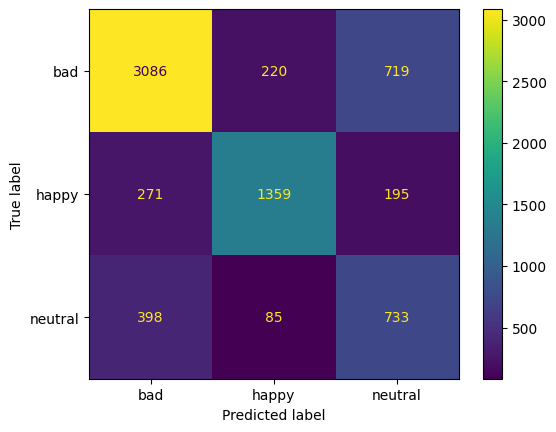

In [86]:
cm = confusion_matrix(test_real_labels, test_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=images_y_ohe.categories_[0])
disp.plot()
plt.show()

In [93]:
model.export("./new_model/")

Saved artifact at './new_model/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_474')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  140547164070208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140547164064400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140547164073376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140547164068448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140547164071792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140547164076368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140547164111616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140547164114256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140547164112496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140547164112672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14054716411883

In [98]:
!zip -r model.zip /kaggle/working/new_model

  adding: kaggle/working/new_model/ (stored 0%)
  adding: kaggle/working/new_model/saved_model.pb (deflated 91%)
  adding: kaggle/working/new_model/variables/ (stored 0%)
  adding: kaggle/working/new_model/variables/variables.index (deflated 78%)
  adding: kaggle/working/new_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: kaggle/working/new_model/fingerprint.pb (stored 0%)
  adding: kaggle/working/new_model/assets/ (stored 0%)


In [103]:
model.save_weights('/kaggle/working/my_model_weights.weights.h5')

In [104]:
new_model = create_model(
    input_shape=(128, 128, 3),
    output_shape=3
)
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,717,259 (25.62 MB)

 Trainable params: 2,227,715 (8.50 MB)

 Non-trainable params: 34,112 (133.25 KB)

 Optimizer params: 4,455,432 (17.00 MB)

In [105]:
new_model.load_weights("/kaggle/working/my_model_weights.weights.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 318 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [106]:
new_model.evaluate(test_x, test_y)

221/221 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.7774 - loss: 0.9421


[1.283549189567566, 0.7328049540519714]

In [115]:
import pickle
pickle.dump(images_y_ohe, open("facial_expr_label_encoder.pkl", "wb"))

In [112]:
images_y_ohe.set_params({"handle_unknown":"infrequent_if_exist"})

TypeError: BaseEstimator.set_params() takes 1 positional argument but 2 were given